## Env

In [ ]:
%load_ext autoreload
%autoreload 2

In [86]:
import os
import gc
import ast
import sys 
import time
import tqdm
import json
import math
import copy
import random
import numpy as np
import pandas as pd
import itertools
from einops import rearrange
from copy import deepcopy
from pathlib import Path
from pprint import pprint
from datetime import datetime
from dataclasses import dataclass, field
from typing import Optional, Any, List, Union, Tuple, Dict, Mapping
from collections import defaultdict, OrderedDict, Counter

import re
import torch
import transformers
import huggingface_hub
from PIL import Image

from transformers import (AutoConfig, AutoTokenizer, AutoProcessor,
                          set_seed, GenerationConfig, Qwen2VLForConditionalGeneration)

from datasets import Dataset, DatasetDict
from datasets import load_dataset, load_from_disk
import trl
from trl import (GRPOConfig, GRPOTrainer, ModelConfig, 
                ScriptArguments, TrlParser, get_peft_config)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

import warnings
warnings.filterwarnings("ignore")

In [87]:
print("transformers ==", transformers.__version__)
print("torch ==", torch.__version__)
print("trl ==", trl.__version__)

transformers == 4.49.0.dev0
torch == 2.5.1+cu124
trl == 0.16.0


In [4]:
from huggingface_hub import login
access_token = "your-token"
login(access_token)

In [5]:
import wandb
os.environ["WANDB_MODE"] = "online"
os.environ["WANDB_API_KEY"] = "your-token"

os.environ["WANDB_PROJECT"] = "video-r1"  # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "false"  # log all model checkpoints
os.environ["WANDB_WATCH"] = "all"

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.cuda.device(0)

In [7]:
cd /home/jovyan/shares/SR004.nfs2/abdullaeva/reasoning/notebooks

/home/jovyan/shares/SR004.nfs2/abdullaeva/reasoning/notebooks


In [8]:
sys.path.append('/home/jovyan/shares/SR004.nfs2/abdullaeva/reasoning/Video-GRPO-tutorial/open_r1')

In [9]:
from trainer import Qwen2VLGRPOTrainer, Qwen2VLGRPOVLLMTrainerModified

In [10]:
@dataclass
class GRPOScriptArguments(ScriptArguments):
    """
    Script arguments for the GRPO training script.

    Args:
        reward_funcs (`list[str]`):
            List of reward functions. Possible values: 'accuracy', 'format'.
    """

    reward_funcs: list[str] = field(
        default_factory=lambda: ["accuracy", "format"],
        metadata={"help": "List of reward functions. Possible values: 'accuracy', 'format'"},
    )
    max_pixels: Optional[int] = field(
        default=12845056,
        metadata={"help": "Maximum number of pixels for the image"},
    )
    min_pixels: Optional[int] = field(
        default=3136,
        metadata={"help": "Minimum number of pixels for the image"},
    )
    temporal: Optional[bool] = field(
        default=True,
        metadata={"help": "whether using temporal GRPO"},
    )
    len_control: Optional[bool] = field(
        default=True,
        metadata={"help": "whether using length reward"},
    )
    video_data_dir: Optional[str] = field(
        default="",
        metadata={"help": "a path for video files"},
    )

In [11]:
def accuracy_reward(completions, solution, **kwargs):
    
    def extract_answer(text):
        pattern = r'<answer>\s*(.*?)\s*</answer>'
        match = re.search(pattern, text, re.DOTALL)
        if match:
            return match.group(1).strip()
        return ""

    def normalize_number(num_str):
        try:
            num_str = num_str.replace(',', '')
            return float(num_str)
        except Exception as e:
            print(f"Error converting '{num_str}' to float: {e}")
            return None

    def wer(reference, hypothesis):
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        m = len(ref_words)
        n = len(hyp_words)
        d = [[0]*(n+1) for _ in range(m+1)]
        for i in range(m+1):
            d[i][0] = i
        for j in range(n+1):
            d[0][j] = j
        for i in range(1, m+1):
            for j in range(1, n+1):
                if ref_words[i-1] == hyp_words[j-1]:
                    d[i][j] = d[i-1][j-1]
                else:
                    d[i][j] = 1 + min(d[i-1][j], d[i][j-1], d[i-1][j-1])
        return d[m][n] / max(1, m)


    def compute_rouge_score(reference, hypothesis, use_stemmer=True):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=use_stemmer)
        scores = scorer.score(reference, hypothesis)
        average_fmeasure = (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3
        return average_fmeasure
    

    question_type = kwargs['problem_type'][0]
    
    contents = [completion[0]["content"] for completion in completions]
    current_time = datetime.now().strftime("%d-%H-%M-%S-%f")
    rewards = []

    for content, sol in zip(contents, solution):
    
        try:
            output_ans = extract_answer(content)
            gt_ans = extract_answer(sol)
            if question_type == "multiple choice":
                reward = 1.0 if output_ans.strip() == gt_ans.strip() else 0.0
            elif question_type == "numerical":
                gt_has_decimal = ("." in gt_ans) or ("," in gt_ans)
                out_has_decimal = ("." in output_ans) or ("," in output_ans)
                if gt_has_decimal != out_has_decimal:
                    reward = 0.0
                else:
                    gt_number = normalize_number(gt_ans)
                    out_number = normalize_number(output_ans)
                    if gt_number is None or out_number is None:
                        reward = 0.0
                    else:
                        reward = 1.0 if round(gt_number, 2) == round(out_number, 2) else 0.0
            elif question_type == "OCR":
                error_rate = wer(gt_ans, output_ans)
                reward = 1 - error_rate
                reward = max(0.0, min(1.0, reward))
            elif question_type == "free-form":
                score = compute_rouge_score(gt_ans, output_ans)
                reward = max(0.0, min(1.0, score))
            elif question_type == "regression":
                gt_number = normalize_number(gt_ans)
                out_number = normalize_number(output_ans)
                if gt_number is None or out_number is None:
                    reward = 0.0
                rel_diff = (abs(out_number - gt_number) + 1e-9) / (abs(gt_number) + 1e-9)
                rel_diff = min(1.0, max(0.0, rel_diff))
                reward = 1 - rel_diff
            else:
                reward = 0.0
        except Exception as e:
            print(f"Error in reward_fn for question_type '{question_type}': {e}")
            reward = 0.0
    
        rewards.append(reward)
        
        if os.getenv("DEBUG_MODE") == "true":
            log_path = os.getenv("LOG_PATH")
            # local_rank = int(os.getenv("LOCAL_RANK", 0))
            with open(log_path, "a", encoding="utf-8") as f:
                f.write(f"------------- {current_time} Accuracy reward: {reward} -------------\n")
                f.write(f"Content: {content}\n")
                f.write(f"Solution: {sol}\n")
            
    return rewards


def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<think>.*?</think>\s*<answer>.*?</answer>"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.fullmatch(pattern, content, re.DOTALL) for content in completion_contents]
    return [1.0 if match else 0.0 for match in matches]


reward_funcs_registry = {
    "accuracy": accuracy_reward,
    "format": format_reward,
}

In [12]:
# Get reward functions
reward_funcs = ["accuracy", "format"]
reward_funcs = [reward_funcs_registry[func] for func in reward_funcs]

## Dataset

In [13]:
! pwd

/home/jovyan/shares/SR004.nfs2/abdullaeva/reasoning/notebooks


In [14]:
VIDEO_DATA_DIR = ""  # source dir for video files
dataset_name = "/video-r1-tutorial-data/NextQA_0_30_s_nextqa.json"

In [15]:
# Read as simple file
with open(dataset_name, 'r') as f:
    dataset = json.load(f)
print(len(dataset))

video_paths = [d['video_path'] for d in dataset]
print(f"Total samples: {len(video_paths)}")
print(f"Unique videos: {len(list(set(video_paths)))}")

2523
Total samples: 2523
Unique videos: 1296


In [16]:
dataset_config = None
if dataset_name.endswith('.json') or dataset_name.endswith('.jsonl'):
    dataset =  DatasetDict({"train": Dataset.from_json(dataset_name)})
else:
    # Load the dataset
    dataset = load_dataset(dataset_name, name=dataset_config)

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'data_type', 'problem_type', 'options', 'solution', 'path', 'data_source', 'video_path'],
        num_rows: 2523
    })
})

In [18]:
dataset['train'][0]

{'problem_id': 407,
 'problem': 'Why does the man use the lever of the fishing rod towards the end?\nOptions:',
 'data_type': 'video',
 'problem_type': 'multiple choice',
 'options': ['A. man in red moved oars wrongly.',
  'B. let lady come down.',
  'C. to catch the fish.',
  'D. for balance.',
  'E. to fix the rod.'],
 'solution': '<answer>C</answer>',
 'path': './NeXT-QA/NextQA/NExTVideo/0090/5338735328.mp4',
 'data_source': 'NeXT-QA/0_30_s_nextqa',
 'video_path': '/home/jovyan/shares/SR004.nfs2/data/LLaVA-Video-178K/LLaVA-Video-178K/0_30_s_nextqa/NextQA/NExTVideo/0090/5338735328.mp4'}

In [19]:
Counter(dataset['train']['problem_type'])

Counter({'multiple choice': 2523})

### Prompts

In [20]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)
print(SYSTEM_PROMPT)

A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>


In [21]:
QUESTION_TEMPLATE = (
    "{Question}\n"
    "Please think about this question as if you were a human pondering deeply. "
    "Engage in an internal dialogue using expressions such as 'let me think', 'wait', 'Hmm', 'oh, I see', 'let's break it down', etc, or other natural language thought expressions "
    "It's encouraged to include self-reflection or verification in the reasoning process. "
    "Provide your detailed reasoning between the <think> </think> tags, and then give your final answer between the <answer> </answer> tags."
)

TYPE_TEMPLATE = {
    "multiple choice": " Please provide only the single option letter (e.g., A, B, C, D, etc.) within the <answer> </answer> tags.",
    "numerical": " Please provide the numerical value (e.g., 42 or 3.14) within the <answer> </answer> tags.",
    "OCR": " Please transcribe text from the image/video clearly and provide your text answer within the <answer> </answer> tags.",
    "free-form": " Please provide your text answer within the <answer> </answer> tags.",
    "regression": " Please provide the numerical value (e.g., 42 or 3.14) within the <answer> </answer> tags."
}
print(QUESTION_TEMPLATE, "\n")
pprint(TYPE_TEMPLATE)

{Question}
Please think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such as 'let me think', 'wait', 'Hmm', 'oh, I see', 'let's break it down', etc, or other natural language thought expressions It's encouraged to include self-reflection or verification in the reasoning process. Provide your detailed reasoning between the <think> </think> tags, and then give your final answer between the <answer> </answer> tags. 

{'OCR': ' Please transcribe text from the image/video clearly and provide your '
        'text answer within the <answer> </answer> tags.',
 'free-form': ' Please provide your text answer within the <answer> </answer> '
              'tags.',
 'multiple choice': ' Please provide only the single option letter (e.g., A, '
                    'B, C, D, etc.) within the <answer> </answer> tags.',
 'numerical': ' Please provide the numerical value (e.g., 42 or 3.14) within '
              'the <answer> </answer> tags

In [22]:
def make_conversation_image(example):
    
    return {
        "prompt": [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": QUESTION_TEMPLATE.format(Question=example["problem"])},
                ],
            },
        ],
    }

    
def make_conversation_video(example):
    return {
        "prompt": [
            {
                "role": "user",
                "content": [
                    {"type": "video"},
                    {"type": "text", "text": QUESTION_TEMPLATE.format(Question=example["problem"])},
                ],
            },
        ],
}
    
def make_conversation_image_and_video(example):
    if example["problem_type"] == 'multiple choice':
        question = example['problem'] + "\n" #+ "Options:\n"
        for op in example["options"]:
            question += op + "\n"
    else:
        question = example['problem']

    
    msg ={
        "prompt": 
           [{
                "role": "user",
                "content": [
                    {
                        "type": example['data_type'],
                    },
                    {
                        "type": "text",
                        "text": QUESTION_TEMPLATE.format(Question=question) + TYPE_TEMPLATE[example['problem_type']]
                    }
                    ]
            }]
        }
    
    return msg


dataset = dataset.map(make_conversation_image_and_video)

In [23]:
dataset['train'][0]

{'problem_id': 407,
 'problem': 'Why does the man use the lever of the fishing rod towards the end?\nOptions:',
 'data_type': 'video',
 'problem_type': 'multiple choice',
 'options': ['A. man in red moved oars wrongly.',
  'B. let lady come down.',
  'C. to catch the fish.',
  'D. for balance.',
  'E. to fix the rod.'],
 'solution': '<answer>C</answer>',
 'path': './NeXT-QA/NextQA/NExTVideo/0090/5338735328.mp4',
 'data_source': 'NeXT-QA/0_30_s_nextqa',
 'video_path': '/home/jovyan/shares/SR004.nfs2/data/LLaVA-Video-178K/LLaVA-Video-178K/0_30_s_nextqa/NextQA/NExTVideo/0090/5338735328.mp4',
 'prompt': [{'content': [{'text': None, 'type': 'video'},
    {'text': "Why does the man use the lever of the fishing rod towards the end?\nOptions:\nA. man in red moved oars wrongly.\nB. let lady come down.\nC. to catch the fish.\nD. for balance.\nE. to fix the rod.\n\nPlease think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such as 'l

In [24]:
print(dataset['train']['prompt'][0][0]['content'][1]['text'])

Why does the man use the lever of the fishing rod towards the end?
Options:
A. man in red moved oars wrongly.
B. let lady come down.
C. to catch the fish.
D. for balance.
E. to fix the rod.

Please think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such as 'let me think', 'wait', 'Hmm', 'oh, I see', 'let's break it down', etc, or other natural language thought expressions It's encouraged to include self-reflection or verification in the reasoning process. Provide your detailed reasoning between the <think> </think> tags, and then give your final answer between the <answer> </answer> tags. Please provide only the single option letter (e.g., A, B, C, D, etc.) within the <answer> </answer> tags.


## Model

In [25]:
# SFT_MODEL_NAME = "Video-R1/Qwen2.5-VL-7B-COT-SFT"
SFT_MODEL_NAME = 'Qwen/Qwen2.5-VL-3B-Instruct'
SFT_MODEL_PATH = ""  # for locally saved weights

In [26]:
OUTPUT_DIR = "../outputs/video_grpo_qwen2.5-vl-3b-coldstart"

training_args = GRPOConfig(
    output_dir=OUTPUT_DIR,
    do_train=True,
    use_vllm=True,
    vllm_device='cuda:0',
    vllm_gpu_memory_utilization=0.5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    per_gpu_train_batch_size=1,
    gradient_accumulation_steps=1,
    learning_rate=1e-06,
    num_train_epochs=1.0,
    max_prompt_length=16384,
    max_completion_length=768,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    beta=0.04,
    max_grad_norm=5,
    temperature=1.0,
    num_generations=2,
    bf16=True,
    logging_steps=1,
    save_steps=100,
    run_name="test",    
)

model_args = ModelConfig(
    model_name_or_path=SFT_MODEL_NAME,
    trust_remote_code=True,
    torch_dtype='bfloat16',
    attn_implementation="flash_attention_2"
)

script_args = GRPOScriptArguments(
    reward_funcs=reward_funcs,
    min_pixels=3136,
    max_pixels=64*28*28,  #501760,
    temporal=True,
    len_control=True,
    dataset_name=dataset_name,
    video_data_dir=VIDEO_DATA_DIR
)

In [27]:
# Create a Trainer for our model
trainer = Qwen2VLGRPOVLLMTrainerModified(
        model=model_args.model_name_or_path,
        reward_funcs=reward_funcs,
        args=training_args,
        script_args=script_args,
        train_dataset=dataset[script_args.dataset_train_split],
        eval_dataset=dataset[script_args.dataset_test_split] if training_args.eval_strategy != "no" else None,
        peft_config=get_peft_config(model_args),
        attn_implementation=model_args.attn_implementation,
        max_pixels=script_args.max_pixels,
        min_pixels=script_args.min_pixels,
)

# fix model dtype, in script accelerate will handel it correctly
trainer.model = trainer.model.type(torch.bfloat16)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in Qwen2_5_VisionTransformerPretrainedModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


vllm is running on:  cuda:0
INFO 07-06 12:58:45 config.py:542] This model supports multiple tasks: {'score', 'classify', 'generate', 'embed', 'reward'}. Defaulting to 'generate'.
WARNING 07-06 12:58:45 arg_utils.py:1079] --enable-prefix-caching is currently not supported for multimodal models in v0 and has been disabled.
WARNING 07-06 12:58:45 cuda.py:95] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
WARNING 07-06 12:58:45 config.py:678] Async output processing is not supported on the current platform type cuda.
INFO 07-06 12:58:45 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='Qwen/Qwen2.5-VL-3B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-VL-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=17152, download_dir=None,

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 07-06 12:58:54 model_runner.py:1115] Loading model weights took 7.1557 GB
WARNING 07-06 12:58:57 model_runner.py:1288] Computed max_num_seqs (min(256, 17152 // 32768)) to be less than 1. Setting it to the minimum value of 1.


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


WARNING 07-06 12:59:00 profiling.py:187] The context length (17152) of the model is too short to hold the multi-modal embeddings in the worst case (32768 tokens in total, out of which {'image': 16384, 'video': 16384} are reserved for multi-modal embeddings). This may cause certain multi-modal inputs to fail during inference, even when the input text is short. To avoid this, you should increase `max_model_len`, reduce `max_num_seqs`, and/or reduce `mm_counts`.
INFO 07-06 12:59:03 worker.py:267] Memory profiling takes 8.38 seconds
INFO 07-06 12:59:03 worker.py:267] the current vLLM instance can use total_gpu_memory (79.25GiB) x gpu_memory_utilization (0.50) = 39.63GiB
INFO 07-06 12:59:03 worker.py:267] model weights take 7.16GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.33GiB; the rest of the memory reserved for KV Cache is 31.05GiB.
INFO 07-06 12:59:03 executor_base.py:110] # CUDA blocks: 56525, # CPU blocks: 7281
INFO 07-06 12:59:03 executor_base.py:115] M

In [28]:
for param_name, param in trainer.model.named_parameters():
    print(f"{param_name} requires grad: {param.requires_grad}")

visual.patch_embed.proj.weight requires grad: True
visual.blocks.0.norm1.weight requires grad: True
visual.blocks.0.norm2.weight requires grad: True
visual.blocks.0.attn.qkv.weight requires grad: True
visual.blocks.0.attn.qkv.bias requires grad: True
visual.blocks.0.attn.proj.weight requires grad: True
visual.blocks.0.attn.proj.bias requires grad: True
visual.blocks.0.mlp.gate_proj.weight requires grad: True
visual.blocks.0.mlp.gate_proj.bias requires grad: True
visual.blocks.0.mlp.up_proj.weight requires grad: True
visual.blocks.0.mlp.up_proj.bias requires grad: True
visual.blocks.0.mlp.down_proj.weight requires grad: True
visual.blocks.0.mlp.down_proj.bias requires grad: True
visual.blocks.1.norm1.weight requires grad: True
visual.blocks.1.norm2.weight requires grad: True
visual.blocks.1.attn.qkv.weight requires grad: True
visual.blocks.1.attn.qkv.bias requires grad: True
visual.blocks.1.attn.proj.weight requires grad: True
visual.blocks.1.attn.proj.bias requires grad: True
visual.bl

In [29]:
# trainer.train()

In [30]:
trainer.args.use_vllm

True

In [31]:
torch.cuda.empty_cache()
gc.collect()

163

## Additional utils

In [32]:
from PIL import Image
from IPython.display import Markdown, display
from torchvision.transforms.functional import to_pil_image

In [33]:
def create_image_grid(images, num_columns=8):
    if not isinstance(images[0], Image.Image):
        images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image

## Step-by-step GRPO reward calculation

In [34]:
from trl.data_utils import apply_chat_template, is_conversational, maybe_apply_chat_template
from trl.models import create_reference_model, prepare_deepspeed, unwrap_model_for_generation
from trl.trainer.grpo_config import GRPOConfig
from trl.trainer.utils import generate_model_card, get_comet_experiment_url, pad

from qwen_vl_utils import process_vision_info
from accelerate.utils.other import is_compiled_module
from accelerate.utils import broadcast_object_list, gather, gather_object

In [35]:
train_dataloader = trainer.get_train_dataloader()

In [36]:
inputs = next(iter(train_dataloader))
print(len(inputs))
inputs[0]

1


{'problem_id': 59250,
 'problem': 'Why is the person moving left and right while coming down the icy mountain?\nOptions:',
 'data_type': 'video',
 'problem_type': 'multiple choice',
 'options': ['A. cross the obstacles.',
  'B. swiped by the person.',
  'C. playing sledding.',
  'D. due to vehicle.',
  'E. huge snowfall.'],
 'solution': '<answer>A</answer>',
 'path': './NeXT-QA/NextQA/NExTVideo/1107/5196189396.mp4',
 'data_source': 'NeXT-QA/0_30_s_nextqa',
 'video_path': '/home/jovyan/shares/SR004.nfs2/data/LLaVA-Video-178K/LLaVA-Video-178K/0_30_s_nextqa/NextQA/NExTVideo/1107/5196189396.mp4',
 'prompt': [{'content': [{'text': None, 'type': 'video'},
    {'text': "Why is the person moving left and right while coming down the icy mountain?\nOptions:\nA. cross the obstacles.\nB. swiped by the person.\nC. playing sledding.\nD. due to vehicle.\nE. huge snowfall.\n\nPlease think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such

In [37]:
prompts = [x["prompt"] for x in inputs]
prompts_text = [maybe_apply_chat_template(example, trainer.processing_class)["prompt"] for example in inputs]
print(prompts_text[0])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|video_pad|><|vision_end|>Why is the person moving left and right while coming down the icy mountain?
Options:
A. cross the obstacles.
B. swiped by the person.
C. playing sledding.
D. due to vehicle.
E. huge snowfall.

Please think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such as 'let me think', 'wait', 'Hmm', 'oh, I see', 'let's break it down', etc, or other natural language thought expressions It's encouraged to include self-reflection or verification in the reasoning process. Provide your detailed reasoning between the <think> </think> tags, and then give your final answer between the <answer> </answer> tags. Please provide only the single option letter (e.g., A, B, C, D, etc.) within the <answer> </answer> tags.<|im_end|>
<|im_start|>assistant



In [38]:
input_copy = copy.deepcopy(inputs[0]['prompt'])
input_copy = trainer.remove_none_from_data(input_copy)

data_type = inputs[0]['data_type']
if data_type == 'image':
    input_copy[0]['content'][0]['image'] = os.path.join(trainer.video_data_dir, inputs[0]['image_path']) 
elif data_type == 'video':
    input_copy[0]['content'][0]['video'] = os.path.join(trainer.video_data_dir, inputs[0]['video_path']) 
input_copy

[{'content': [{'type': 'video',
    'video': '/home/jovyan/shares/SR004.nfs2/data/LLaVA-Video-178K/LLaVA-Video-178K/0_30_s_nextqa/NextQA/NExTVideo/1107/5196189396.mp4'},
   {'text': "Why is the person moving left and right while coming down the icy mountain?\nOptions:\nA. cross the obstacles.\nB. swiped by the person.\nC. playing sledding.\nD. due to vehicle.\nE. huge snowfall.\n\nPlease think about this question as if you were a human pondering deeply. Engage in an internal dialogue using expressions such as 'let me think', 'wait', 'Hmm', 'oh, I see', 'let's break it down', etc, or other natural language thought expressions It's encouraged to include self-reflection or verification in the reasoning process. Provide your detailed reasoning between the <think> </think> tags, and then give your final answer between the <answer> </answer> tags. Please provide only the single option letter (e.g., A, B, C, D, etc.) within the <answer> </answer> tags.",
    'type': 'text'}],
  'role': 'user'

In [39]:
image_inputs, video_inputs, video_kwargs = process_vision_info(input_copy, return_video_kwargs=True)

qwen-vl-utils using decord to read video.


In [40]:
type(video_inputs), video_inputs[0].size(), video_inputs[0].dtype

(list, torch.Size([8, 3, 224, 420]), torch.float32)

In [41]:
video_kwargs

{'fps': [0.4022822814769123]}

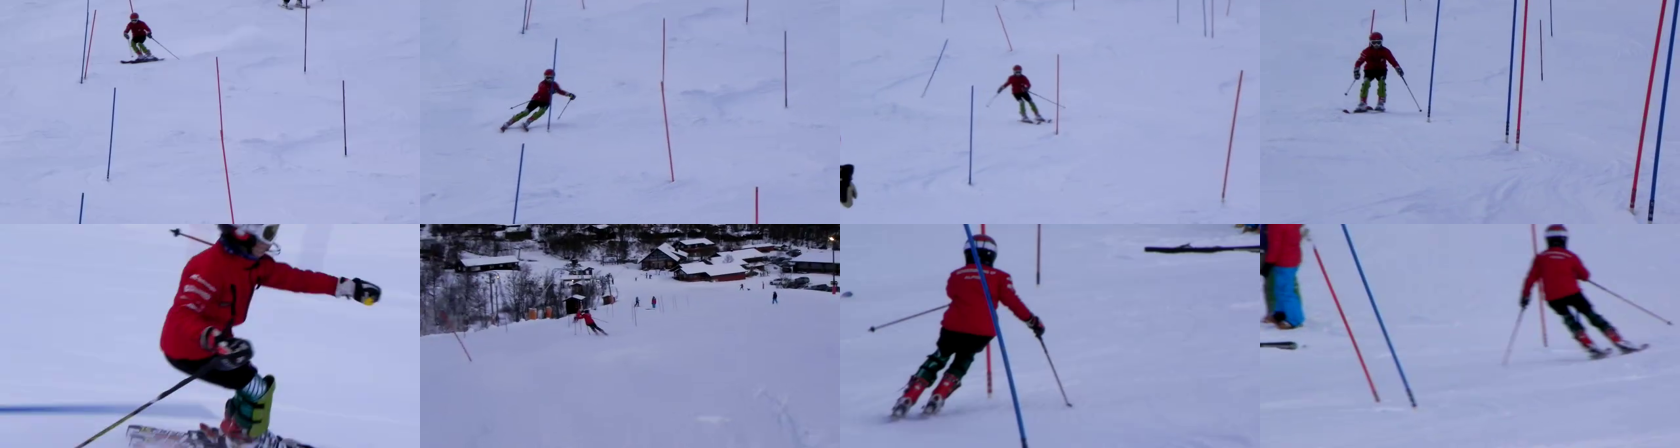

In [42]:
# Visualize our frames
video_frames = [to_pil_image(frame.to(torch.uint8)) for frame in video_inputs[0]]
create_image_grid(video_frames, 4)

In [43]:
def _prepare_input(data: Union[torch.Tensor, Any]) -> Union[torch.Tensor, Any]:
    """
    Prepares one `data` before feeding it to the model, be it a tensor or a nested list/dictionary of tensors.
    """
    if isinstance(data, Mapping):
        return type(data)({k: _prepare_input(v) for k, v in data.items()})
    elif isinstance(data, (tuple, list)):
        return type(data)(_prepare_input(v) for v in data)
    elif isinstance(data, torch.Tensor):
        kwargs = {"device": trainer.args.device}
        if trainer.is_deepspeed_enabled and (torch.is_floating_point(data) or torch.is_complex(data)):
            # NLP models inputs are int/uint and those get adjusted to the right dtype of the
            # embedding. Other models such as wav2vec2's inputs are already float and thus
            # may need special handling to match the dtypes of the model
            kwargs.update({"dtype": trainer.accelerator.state.deepspeed_plugin.hf_ds_config.dtype()})
        return data.to(**kwargs)
    return data

In [44]:
# https://github.com/QwenLM/Qwen2.5-VL/issues/599#issuecomment-2564852067
prompt_inputs = trainer.processing_class(
            text=copy.deepcopy(prompts_text[0]),
            images=image_inputs,
            videos=video_inputs,
            return_tensors="pt",
            padding=True,
            padding_side="left",
            add_special_tokens=False,
        )

In [45]:
# Prepare `inputs` before feeding them to the model, converting them to tensors if they are not already and
# handling potential state.

prompt_inputs = _prepare_input(prompt_inputs)
prompt_inputs['pixel_values_videos'] = prompt_inputs['pixel_values_videos'].type(torch.bfloat16)  # this line is not required in Trainer as accelerate correctly handle data types
mm_data = [[data_type, image_inputs if image_inputs else video_inputs]]

for k, v in prompt_inputs.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.size()} on {v.device} of type: {v.dtype}")
    else:
        print(f"{k}: {v}")

input_ids: torch.Size([1, 404]) on cuda:0 of type: torch.int64
attention_mask: torch.Size([1, 404]) on cuda:0 of type: torch.int64
pixel_values_videos: torch.Size([800, 1176]) on cuda:0 of type: torch.bfloat16
video_grid_thw: torch.Size([1, 3]) on cuda:0 of type: torch.int64
second_per_grid_ts: [1.0]


In [46]:
prompt_ids, prompt_mask = prompt_inputs["input_ids"], prompt_inputs["attention_mask"]

# Deal with too long `input_ids` issue
if trainer.max_prompt_length is not None:
    prompt_ids = prompt_ids[:, -trainer.max_prompt_length :]
    prompt_mask = prompt_mask[:, -trainer.max_prompt_length :]

print(f"prompt_ids: {prompt_ids.size()}")
print(f"prompt_mask: {prompt_mask.size()}")

prompt_ids: torch.Size([1, 404])
prompt_mask: torch.Size([1, 404])


In [47]:
# Calculate temporal reward for video sample
if trainer.temporal and video_inputs:
    indices = torch.randperm(video_inputs[0].size(0))
    print(f"shuffled indices: {indices}")
    shuffled_video_inputs = [video_inputs[0][indices]]
    shuffled_prompt_inputs = trainer.processing_class(
        text=copy.deepcopy(prompts_text[0]),
        images=image_inputs,
        videos=shuffled_video_inputs,
        return_tensors="pt",
        padding=True,
        padding_side="left",
        add_special_tokens=False,
    )
    shuffled_prompt_inputs = _prepare_input(shuffled_prompt_inputs)
    shuffled_prompt_inputs['pixel_values_videos'] = shuffled_prompt_inputs['pixel_values_videos'].type(torch.bfloat16) # this line is not required in Trainer as accelerate correctly handle data types
    shuffled_prompt_ids, shuffled_prompt_mask = shuffled_prompt_inputs["input_ids"], shuffled_prompt_inputs["attention_mask"]
    shuffled_mm_data = [[trainer.accelerator.process_index, data_type, image_inputs if image_inputs else video_inputs]]
    
    if trainer.max_prompt_length is not None:
        shuffled_prompt_ids = shuffled_prompt_ids[:, -trainer.max_prompt_length :]
        shuffled_prompt_mask = shuffled_prompt_mask[:, -trainer.max_prompt_length :]
    print(f"shuffled_prompt_ids: {shuffled_prompt_ids.size()}")
    print(f"shuffled_prompt_mask: {shuffled_prompt_mask.size()}")
else:
    shuffled_mm_data = [None]

shuffled indices: tensor([5, 3, 1, 7, 2, 6, 4, 0])
shuffled_prompt_ids: torch.Size([1, 404])
shuffled_prompt_mask: torch.Size([1, 404])


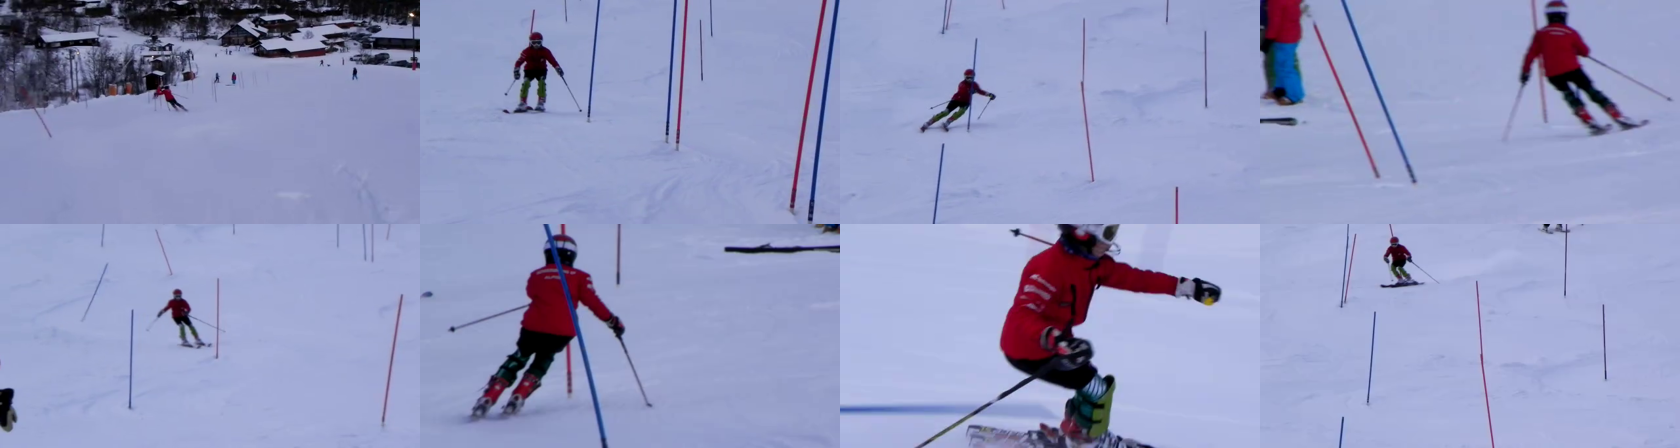

In [48]:
# Visualize shuffled frames
# Visualize our frames
video_frames = [to_pil_image(frame.to(torch.uint8)) for frame in shuffled_video_inputs[0]]
create_image_grid(video_frames, 4)

In [49]:
# Wrap model with vllm for faster generation

trainer._last_loaded_step = 0  # tag to avoid useless loading during grad accumulation

# First, have main process load weights if needed
if trainer.state.global_step != trainer._last_loaded_step:
    with unwrap_model_for_generation(
        trainer.model,
        trainer.accelerator,
        gather_deepspeed3_params=True, 
    ) as unwrapped_model:
        if is_compiled_module(unwrapped_model):  # Check whether the module was compiled with torch.compile()
            state_dict = unwrapped_model._orig_mod.state_dict()
        else:
            state_dict = unwrapped_model.state_dict()
    if trainer.accelerator.is_main_process:
        llm_model = (
            trainer.llm.llm_engine.model_executor.driver_worker.model_runner.model
        )
        llm_model.load_weights(state_dict.items())
    trainer._last_loaded_step = trainer.state.global_step

In [50]:
# Generate completions using vLLM: gather all prompts and use them in a single call in the main process
# `gather_object` - Recursively gather object in a nested list/tuple/dictionary of objects from all devices.
all_prompts_text = gather_object(prompts_text)
all_mm_data = gather_object(mm_data)
all_multimodal_inputs = []  # group into pairs

if trainer.temporal: 
    shuffled_all_mm_data_none = gather_object(shuffled_mm_data)
    shuffled_all_mm_data = [x for x in shuffled_all_mm_data_none if x]
    shuffled_all_multimodal_inputs = []

In [51]:
for prompt, mm_item in zip(all_prompts_text, all_mm_data):
    all_multimodal_inputs.append({"prompt": prompt, "multi_modal_data": {mm_item[0]: mm_item[1]}})

if trainer.temporal and shuffled_all_mm_data != []: 
    for mm_item in shuffled_all_mm_data:    
        shuffled_all_multimodal_inputs.append({"prompt": all_prompts_text[mm_item[0]], "multi_modal_data": {mm_item[1]: mm_item[2]}})

In [52]:
# Create sampling params with num_generations
if trainer.accelerator.is_main_process:
    # Clone to avoid modifying original params
    sampling_params = copy.deepcopy(trainer.sampling_params)
    sampling_params.n = trainer.num_generations
    # Single generate call with all prompts
    outputs = trainer.llm.generate(
        all_multimodal_inputs,
        sampling_params=sampling_params,
        use_tqdm=False,
    )
    # Flatten outputs: [prompt1_gen1, prompt1_gen2, ..., prompt2_gen1, prompt2_gen2, ...]
    completion_ids = [out.token_ids for completion in outputs for out in completion.outputs]                
    
    if trainer.temporal and shuffled_all_mm_data != []:
        # Clone to avoid modifying original params
        shuffled_sampling_params = copy.deepcopy(trainer.sampling_params)
        shuffled_sampling_params.n = trainer.num_generations // 2
        # Single generate call with all prompts
        shuffled_outputs = trainer.llm.generate(
            shuffled_all_multimodal_inputs,
            sampling_params=shuffled_sampling_params,
            use_tqdm=False,
        )
        # Flatten outputs: [prompt1_gen1, prompt1_gen2, ..., prompt2_gen1, prompt2_gen2, ...]
        shuffled_completion_ids = [out.token_ids for completion in shuffled_outputs for out in completion.outputs]

In [53]:
for i in range(len(completion_ids)):
    decoded = trainer.tokenizer.decode(completion_ids[i])
    print(f"#{i}: {decoded}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


#0: A. cross the obstacles.<|im_end|>
#1: A. cross the obstacles.

The person is skiing down an icy mountain with poles in the snow. They are trying to avoid falling off the side of the mountain and are therefore moving left and right to navigate the obstacles.<|im_end|>


In [54]:
for i in range(len(shuffled_completion_ids)):
    decoded = trainer.tokenizer.decode(completion_ids[i])
    print(f"#{i}: {decoded}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


#0: A. cross the obstacles.<|im_end|>


In [55]:
# Broadcast a list of picklable objects form one process to the others.
# broadcast and slice
completion_ids = broadcast_object_list(completion_ids, from_process=0)
process_slice = slice(
    trainer.accelerator.process_index * len(prompts) * trainer.num_generations,
    (trainer.accelerator.process_index + 1) * len(prompts) * trainer.num_generations,
)
completion_ids = completion_ids[process_slice]

In [56]:
# Pad the completions, and concatenate them with the prompts
completion_ids = [torch.tensor(ids, device=trainer.args.device) for ids in completion_ids]
completion_ids = pad(
    completion_ids, padding_value=trainer.processing_class.pad_token_id
)
prompt_ids = prompt_ids.repeat_interleave(trainer.num_generations, dim=0)
prompt_completion_ids = torch.cat([prompt_ids, completion_ids], dim=1)

prompt_length = prompt_ids.size(1)
print('prompt_length:', prompt_length)

prompt_ids = prompt_completion_ids[:, :prompt_length]
completion_ids = prompt_completion_ids[:, prompt_length:]
prompt_mask = prompt_mask.repeat_interleave(trainer.num_generations, dim=0)
print(f'prompt_ids: {prompt_ids.size()}')
print(f'completion_ids: {completion_ids.size()}')
print(f'prompt_mask: {prompt_mask.size()}')

prompt_length: 404
prompt_ids: torch.Size([2, 404])
completion_ids: torch.Size([2, 45])
prompt_mask: torch.Size([2, 404])


In [57]:
device = trainer.accelerator.device

if trainer.temporal and shuffled_all_mm_data != []:
    # broadcast and slice
    shuffled_completion_ids = broadcast_object_list(shuffled_completion_ids, from_process=0)
    process_id_list = []
    for mm_item in shuffled_all_mm_data:
        process_id_list += [mm_item[0]] * len(prompts) * (trainer.num_generations // 2)
        
    if video_inputs:
        cur_shuffled_completion_ids = []
        for i in range(len(process_id_list)):
            if trainer.accelerator.process_index == process_id_list[i]:
                cur_shuffled_completion_ids.append(shuffled_completion_ids[i])

        # Pad the completions, and concatenate them with the prompts
        cur_shuffled_completion_ids = [torch.tensor(ids, device=trainer.args.device) 
                                       for ids in cur_shuffled_completion_ids]
        cur_shuffled_completion_ids = pad(
            cur_shuffled_completion_ids, padding_value=trainer.processing_class.pad_token_id
        )
        shuffled_completion_ids = cur_shuffled_completion_ids

    print(f'prompt_ids: {prompt_ids.size()}')
    print(f'shuffled_completion_ids: {shuffled_completion_ids.size()}')

prompt_ids: torch.Size([2, 404])
shuffled_completion_ids: torch.Size([1, 768])


In [58]:
# Mask everything after the first EOS token
is_eos = completion_ids == trainer.processing_class.eos_token_id
eos_idx = torch.full((is_eos.size(0),), is_eos.size(1), dtype=torch.long, device=device)
eos_idx[is_eos.any(dim=1)] = is_eos.int().argmax(dim=1)[is_eos.any(dim=1)]
sequence_indices = torch.arange(is_eos.size(1), device=device).expand(is_eos.size(0), -1)
completion_mask = (sequence_indices <= eos_idx.unsqueeze(1)).int()

_ = prompt_inputs.pop("input_ids")
_ = prompt_inputs.pop("attention_mask")

In [59]:
torch.cuda.empty_cache()
gc.collect()

0

In [61]:
# print(f"pixel_values_videos: {prompt_inputs['pixel_values_videos'].size()}")
# print(f"video_grid_thw: {prompt_inputs['video_grid_thw'].size()}")

# if data_type == 'image':
    # prompt_inputs["pixel_values"] = prompt_inputs["pixel_values"].repeat(len(prompt_completion_ids), 1)
    # prompt_inputs["image_grid_thw"] = prompt_inputs["image_grid_thw"].repeat(len(prompt_completion_ids), 1)

if data_type == 'video':
    # prompt_inputs["pixel_values_videos"] = prompt_inputs["pixel_values_videos"].repeat(len(prompt_completion_ids), 1)
    # prompt_inputs["video_grid_thw"] = prompt_inputs["video_grid_thw"].repeat(len(prompt_completion_ids), 1)
    if 'second_per_grid_ts' in prompt_inputs:
        del prompt_inputs["second_per_grid_ts"]

print(f"pixel_values_videos: {prompt_inputs['pixel_values_videos'].size()}")
print(f"video_grid_thw: {prompt_inputs['video_grid_thw'].size()}")

pixel_values_videos: torch.Size([800, 1176])
video_grid_thw: torch.Size([1, 3])


In [62]:
trainer._get_per_token_logps??

Signature: trainer._get_per_token_logps(model, input_ids, **kwargs)
Docstring: <no docstring>
Source:   
    def _get_per_token_logps(self, model, input_ids, **kwargs):
        # logits = model(input_ids, attention_mask=attention_mask, pixel_values=pixel_values, image_grid_thw=image_grid_thw).logits  # (B, L, V)
        # import pdb
        # pdb.set_trace()
        logits = model(input_ids, **kwargs).logits
        logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred
        input_ids = input_ids[:, 1:]  # (B, L-1), exclude the first input ID since we don't have logits for it
        # Compute the log probabilities for the input tokens. Use a loop to reduce memory peak.
        per_token_logps = []
        for logits_row, input_ids_row in zip(logits, input_ids):
            log_probs = logits_row.log_softmax(dim=-1)
            token_log_prob = torch.gather(log_probs, dim=1, index=input_ids_row.unsqueeze(1)).squeeze(1)
            pe

In [65]:
def _get_per_token_logps(model, input_ids, num_generations: int, **kwargs):
    """
    Compute the log probabilities for the input tokens. 
    Use a loop to reduce memory peak.
    """
    per_token_logps = []
    for i in range(num_generations):
        input_ids_ = input_ids[i].unsqueeze(0)  # [bs, L]
        logits = model(input_ids_, **kwargs).logits
        # Make a shift
        logits = logits[:, :-1, :]  # (bs, L-1, V), exclude the last logit: it corresponds to the next token pred
        input_ids_ = input_ids_[:, 1:]  # (bs, L-1), exclude the first input ID since we don't have logits for it
        
        log_probs = logits.squeeze(0).log_softmax(dim=-1)
        token_log_prob = torch.gather(log_probs, dim=1, index=input_ids_[0].unsqueeze(1)).squeeze(1)
        per_token_logps.append(token_log_prob)
        
        torch.cuda.empty_cache()
        gc.collect()
    
    per_token_logps = torch.stack(per_token_logps)
    return per_token_logps

In [63]:
# Compute the log probabilities - original in Trainer
# per_token_logps = self._get_per_token_logps(model, prompt_completion_ids, **prompt_inputs)

# Compute the log probabilities for the input tokens. Use a loop to reduce memory peak.
per_token_logps = _get_per_token_logps(trainer.model, 
                                       prompt_completion_ids, 
                                       trainer.num_generations,
                                       **prompt_inputs)
# Get rid of the prompt (-1 because of the shift done in get_per_token_logps)
per_token_logps = per_token_logps[:, prompt_length - 1 :]
print(f"per_token_logps: {per_token_logps.size()}")

gc.collect()
torch.cuda.empty_cache()

per_token_logps: torch.Size([2, 45])


In [67]:
# Calculate logprobs for our reference model
with torch.inference_mode():
    if trainer.ref_model is not None:
        ref_per_token_logps = _get_per_token_logps(trainer.ref_model, 
                                                   prompt_completion_ids, 
                                                   trainer.num_generations,
                                                   **prompt_inputs)
    else:
        with trainer.accelerator.unwrap_model(model).disable_adapter():
            ref_per_token_logps = _get_per_token_logps(model, 
                                                       prompt_completion_ids, 
                                                       trainer.num_generations,
                                                       **prompt_inputs)
ref_per_token_logps = ref_per_token_logps[:, prompt_length - 1 :]

x_clamped = torch.clamp(ref_per_token_logps - per_token_logps, min=-10, max=10)  # 限制 x 的范围
per_token_kl = torch.exp(x_clamped) - x_clamped - 1

gc.collect()
torch.cuda.empty_cache()

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


In [73]:
# Calculate rewards from temporal reward function
if trainer.temporal and video_inputs:
    shuffled_completions = trainer.processing_class.batch_decode(shuffled_completion_ids, 
                                                                 skip_special_tokens=True)
    if is_conversational(inputs[0]):
        shuffled_completions = [[{"role": "assistant", "content": shuffled_completion}] 
                                for shuffled_completion in shuffled_completions]
        
    # Compute the rewards
    shuffled_prompts = [prompt for prompt in prompts for _ in range(trainer.shuffled_num_generations)]
    shuffled_rewards_per_func = torch.zeros(len(shuffled_prompts), len(trainer.reward_funcs), device=device)
    for i, (reward_func, reward_processing_class) in enumerate(
        zip(trainer.reward_funcs, trainer.reward_processing_classes)
    ):
        # Repeat all input columns (but "prompt" and "completion") to match the number of generations
        shuffled_reward_kwargs = {key: [] for key in inputs[0].keys() if key not in ["prompt", "completion"]}
        for key in shuffled_reward_kwargs:
            for example in inputs:
                # Repeat each value in the column for `num_generations` times
                shuffled_reward_kwargs[key].extend([example[key]] * trainer.shuffled_num_generations)
        shuffled_output_reward_func = reward_func(prompts=shuffled_prompts, 
                                                  completions=shuffled_completions, 
                                                  **shuffled_reward_kwargs)
        shuffled_rewards_per_func[:, i] = torch.tensor(shuffled_output_reward_func, 
                                                       dtype=torch.float32, 
                                                       device=device)

In [74]:
shuffled_rewards_per_func

tensor([[0., 0.]], device='cuda:0')

In [75]:
# Decode the generated completions
completions = trainer.processing_class.batch_decode(
    completion_ids, skip_special_tokens=True
)
if is_conversational(inputs[0]):
    completions = [
        [{"role": "assistant", "content": completion}]
        for completion in completions
    ]

# Compute the rewards
prompts = [prompt for prompt in prompts for _ in range(trainer.num_generations)]
rewards_per_func = torch.zeros(
    len(prompts), len(trainer.reward_funcs), device=device
)
for i, (reward_func, reward_processing_class) in enumerate(
    zip(trainer.reward_funcs, trainer.reward_processing_classes)
):
    reward_kwargs = {
        key: []
        for key in inputs[0].keys()
        if key not in ["prompt", "completion"]
    }
    for key in reward_kwargs:
        for example in inputs:
            # Repeat each value in the column for `num_generations` times
            reward_kwargs[key].extend([example[key]] * trainer.num_generations)
    output_reward_func = reward_func(
        prompts=prompts, completions=completions, **reward_kwargs
    )
    rewards_per_func[:, i] = torch.tensor(
        output_reward_func, dtype=torch.float32, device=device
    )

rewards_per_func

tensor([[0., 0.],
        [0., 0.]], device='cuda:0')

In [76]:
if trainer.temporal and video_inputs:
    temporal_rewards_per_func = rewards_per_func.clone()
    
    acc_mean = temporal_rewards_per_func[:, 0].mean()
    shuffled_acc_mean = shuffled_rewards_per_func[:, 0].mean()
    print(f"correct = {acc_mean} vs. shuffled = {shuffled_acc_mean}")

    if acc_mean >= 0.8 * shuffled_acc_mean:
        mask = temporal_rewards_per_func[:, 0] > 0.1
        temporal_rewards_per_func[mask, 0] = temporal_rewards_per_func[mask, 0] + 0.3
        temporal_rewards = torch.tensor([1.0]).to('cuda')
    else:
        temporal_rewards = torch.tensor([0.0]).to('cuda')
else:
    temporal_rewards =  torch.tensor([0.5]).to('cuda')

correct = 0.0 vs. shuffled = 0.0


In [77]:
# Sum the rewards from all reward functions
if trainer.temporal and video_inputs:
    rewards = temporal_rewards_per_func.sum(dim=1)
else:
    rewards = rewards_per_func.sum(dim=1)

rewards

tensor([0., 0.], device='cuda:0')

In [80]:
# Calculate length reward 
if trainer.len_control:
    mem_rewards = [0] * trainer.num_generations
    mask = rewards_per_func[:, 0] > 0.1
    lenth_list = completion_mask.sum(1)
    selected_indices = torch.nonzero(mask, as_tuple=True)[0].tolist()
            
    if len(selected_indices) > 1:     
        for idx in selected_indices:
            if 320 <= lenth_list[idx] <= 512:
                rewards[idx] += 0.2

print(rewards)
print(completion_mask.sum(1))

tensor([0., 0.], device='cuda:0')
tensor([ 7, 45], device='cuda:0')


In [83]:
# Compute grouped-wise rewards
mean_grouped_rewards = rewards.view(-1, trainer.num_generations).mean(dim=1)
std_grouped_rewards = rewards.view(-1, trainer.num_generations).std(dim=1)

# Normalize the rewards to compute the advantages
mean_grouped_rewards = mean_grouped_rewards.repeat_interleave(trainer.num_generations, dim=0)
std_grouped_rewards = std_grouped_rewards.repeat_interleave(trainer.num_generations, dim=0)
advantages = (rewards - mean_grouped_rewards) / (std_grouped_rewards + 1e-4)
print(f"advantages: {advantages}")

# x - x.detach() allows for preserving gradients from x
per_token_loss = torch.exp(per_token_logps - per_token_logps.detach()) * advantages.unsqueeze(1)
per_token_loss = -(per_token_loss - trainer.beta * per_token_kl)

loss = ((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()
loss

advantages: tensor([0., 0.], device='cuda:0')


tensor(4.8005e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [84]:
torch.cuda.empty_cache()
gc.collect()

1125